# Attribute importance ranking for synthetic data with known change points
The process change points are known. Hence, no change point detection algorithm needs to be used.

In [1]:
import pm4py
import helper
import pandas as pd

In [2]:
# data_file_path = 'data/synthetic/maardji et al 2013_xes_attributes/logs/ROI/ROI2.5k.xes'
# data_file_path = 'data/synthetic/maardji et al 2013_xes_attributes/logs/cb/cb10k.xes'
data_file_path = 'data/synthetic/generated/new_attribute_values/2500_sudden_5_00.xes'

## Load an event log

In [3]:
# Display the data info
data_info = helper.get_data_information(data_file_path)
data_info

change_points = data_info['change_points']

In [4]:
# load the event log into pm4py
from pm4py.objects.log.importer.xes import importer as xes_importer
event_log = xes_importer.apply(data_file_path)

C:\Users\Lennart\Tools\Anaconda3\envs\concept_drift\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
parsing log, completed traces :: 100%|███████████████████████████████████████████| 2500/2500 [00:02<00:00, 1031.09it/s]


In [5]:
from processdrift.framework import drift_detection
from processdrift.framework import drift_explanation
from processdrift.framework import feature_extraction
from processdrift.framework import pop_comparison
from processdrift.framework import windowing

In [6]:
# build the primary process drift detector
primary_feature_extractor = feature_extraction.RelationalEntropyFeatureExtractor()
primary_window_generator = windowing.FixedSizeWindowGenerator(window_size=150, slide_by=1)
primary_population_comparer = pop_comparison.KSTestPopComparer()
primary_threshold = 0.5
primary_process_drift_detector = drift_detection.DriftDetector(primary_feature_extractor, 
                                                               primary_window_generator,
                                                               primary_population_comparer, 
                                                               threshold=primary_threshold)

In [7]:
# build the secondary process drift detectors
secondary_window_generator = primary_window_generator
secondary_population_comparer = pop_comparison.HellingerDistanceComparer()
secondary_threshold = primary_threshold
secondary_exclude_attributes = ['concept:name']
secondary_drift_detectors = drift_detection.get_all_attribute_drift_detectors(event_log,
                                                                         secondary_window_generator, 
                                                                         secondary_population_comparer, 
                                                                         threshold=secondary_threshold,
                                                                         exclude_attributes=secondary_exclude_attributes)

In [8]:
drift_explainer = drift_explanation.DriftExplainer(primary_process_drift_detector, secondary_drift_detectors)

In [9]:
primary_and_secondary_change_series = drift_explainer.get_primary_and_secondary_change_series(event_log)
primary_and_secondary_change_series

(151     1.0
 152     1.0
 153     1.0
 154     1.0
 155     1.0
        ... 
 2347    1.0
 2348    1.0
 2349    1.0
 2350    1.0
 2351    1.0
 Length: 2201, dtype: float64,
 {'Attribute: irrelevant_attribute_1': 151     0.828667
  152     0.828667
  153     0.830481
  154     0.832001
  155     0.832001
            ...   
  2347    0.921384
  2348    0.932848
  2349    0.932848
  2350    0.932848
  2351    0.944159
  Length: 2201, dtype: float64,
  'Attribute: relevant_attribute_3': 151     0.968219
  152     0.966039
  153     0.969754
  154     0.970466
  155     0.969777
            ...   
  2347    0.959916
  2348    0.970276
  2349    0.975454
  2350    0.979044
  2351    0.975437
  Length: 2201, dtype: float64,
  'Attribute: irrelevant_attribute_5': 151     0.929939
  152     0.929939
  153     0.930729
  154     0.939860
  155     0.940624
            ...   
  2347    0.948021
  2348    0.942554
  2349    0.939339
  2350    0.932412
  2351    0.928595
  Length: 2201, dtype: flo

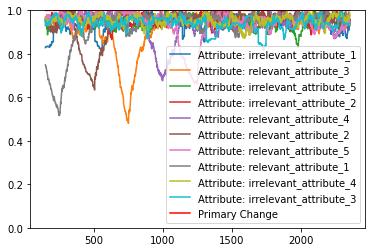

In [10]:
drift_explanation.plot_primary_and_secondary_change_series(primary_and_secondary_change_series)